## Past Data in Siphon

You can easily access past data using Siphon, you'll just have to know the address ahead of time, similar to what you had to due for accessing the NCEP/NCAR Reanalysis data via netCDF4 module.

NCEI is running a THREDDS that is a great resource of past gridded datasets, check out the link

https://www.ncdc.noaa.gov/data-access/model-data/model-datasets

For example, there are gridded NAM analyses going back to March of 2004 available on this site!

If you click through on the website you will be able to obtain the necessary web address to put in the the Siphon NCSS function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from datetime import datetime, timedelta
from netCDF4 import num2date
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import metpy.calc as mcalc
from metpy.units import units

Pulling in your dataset is very similar to what you did for a netCDF file through OPeNDAP, we just need the web address for the grib file within the NCSS section. Then we build our query in the same manner as we did before for the latest GFS analysis to get our data into our notebook.

In [2]:
ncss = NCSS('https://www.ncei.noaa.gov/thredds/ncss/grid/namanl/200907/20090727/namanl_218_20090727_1200_000.grb')

# We can subset on a number of different aspects of
#  the data: time, lat/lon, variable, etc.
# First initiate the query
query = ncss.query()

# Now let's build the query for Latest GFS Run, 
#  we want all of the times from the
# latest GFS run and accept them in netCDF-4 convension
query.all_times()

# Now lets subset and only bring in the Geopotential Height data
# NAM = Geopotential_height
# GFS = Geopotential_height_isobaric
query.variables('Geopotential_height_isobaric',
                'u-component_of_wind_isobaric', 
                'v-component_of_wind_isobaric')

# Let's not bring in the whole globe, but just a subset over the U.S.
# Set the lat/lon box for the data you want to pull in.
# lonlat_box(north_lat,south_lat,east_lon,west_lon)
query.add_lonlat().lonlat_box(-140,-50,10,70)

# NOMADS is an older version THREDDS server, so we can't subset level
# Now specify the desired level 50000 = 50000 Pa = 500 hPa
#query.vertical_level(50000)

# Actually getting the data
data = ncss.get_data(query)

In [3]:
# Seeing what data we got from our query by inspecting some of the metadata.
print(data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Originating_or_generating_Center: US National Weather Service, National Centres for Environmental Prediction (NCEP)
    Originating_or_generating_Subcenter: 0
    GRIB_table_version: 0,129
    Generating_process_or_model: MESO NAM Model (currently 12 km)
    Conventions: CF-1.6
    history: Read using CDM IOSP GribCollection v3
    featureType: GRID
    History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)
Original Dataset = /global/dataset/model/namanl/200907/20090727/namanl_218_20090727_1200_000.grb; Translation Date = 2017-10-31T21:36:12.206Z
    geospatial_lat_min: 13.9780903247
    geospatial_lat_max: 57.2813577989
    geospatial_lon_min: -152.935694012
    geospatial_lon_max: -49.2931200277
    dimensions(sizes): time1(1), isobaric(39), y(409), x(614)
    variables(dimensions): float32 u-component_of_wind_isobaric(time1,isobaric,y,x), float64 time1(time1), f

### Get Data Arrays

Here we subset the different elements of our data so that we will be able to plot things a little later. Since we have multiple levels from our data query, we'll have to find the appropriate levels for 500 hPa.

We want,
* latitude
* longitude
* vertical levels
* time
* geopotential height
* u and v components of the wind

In [4]:
# Get the name of the dimensions because grib is stupid
dtime = data.variables['Geopotential_height_isobaric'].dimensions[0]
dlev = data.variables['Geopotential_height_isobaric'].dimensions[1]

# Get the dimension data
lats = data.variables['lat'][:]
lons = data.variables['lon'][:]
levs = data.variables[dlev][:]
time = data.variables[dtime]

# Create a valid times array using the num2date function from netCDF4
vtimes = num2date(time[:],time.units)
print(vtimes)

# Bring in only the 500-hPa Heights
hght = data.variables['Geopotential_height_isobaric'][0,:,:,:] * units.meter
uwnd = data.variables['u-component_of_wind_isobaric'][0,:,:,:] * units('m/s')
vwnd = data.variables['v-component_of_wind_isobaric'][0,:,:,:] * units('m/s')
print(hght.shape)

# Select the index value for the 850 and 500 hPa levels of our heights and wind components
ilev850 = np.where(levs==850)[0][0]
ilev500 = np.where(levs==500)[0][0]

# Smooth our height field to a more "synoptic" view and slice our array for particular levels
# Smoothing must be done on a 2D arary!
Z_500 = ndimage.gaussian_filter(hght[ilev500,:,:], sigma=1.5, order=0) * units.meter
Z_850 = ndimage.gaussian_filter(hght[ilev850,:,:], sigma=1.5, order=0) * units.meter

# Subest wind components for 500 hPa and set units to knots
uwnd_500 = uwnd[ilev500].to('knots')
vwnd_500 = vwnd[ilev500].to('knots')

[datetime.datetime(2009, 7, 27, 12, 0)]
(39, 409, 614)


### Lat/Lon is 2D

Since we have chosen NAM data, our latitude and longitudes are already 2D.

Why are they 2D?

Because the NAM is in a projected coordinate (Lambert Conformal) that means we are not on a perfect grid. So when requesting the lat/lon values for our data we must get a 2D lat and lon fields.

In [5]:
# Print lat values and shape
print(lats)
print(lats.shape)

[[ 14.04504201  14.07558842  14.1060566  ...,  16.28048517  16.25653068
   16.23249174]
 [ 14.14837752  14.17895812  14.20946039 ...,  16.3862861   16.3623056
   16.33824055]
 [ 14.25174017  14.28235492  14.31289124 ...,  16.49211125  16.46810476
   16.44401363]
 ..., 
 [ 54.32995965  54.36879347  54.4075165  ...,  57.14156731  57.11176747
   57.08185535]
 [ 54.41570948  54.45454652  54.49327273 ...,  57.22745413  57.19765387
   57.16774132]
 [ 54.50135067  54.54019084  54.57892013 ...,  57.31322611  57.28342552
   57.2535126 ]]
(409, 614)


In [6]:
# Print lon values and shape
print(lons)
print(lons.shape)

[[-134.01859187 -133.91206184 -133.80548237 ...,  -64.8616413   -64.75145416
   -64.64130765]
 [-134.05014483 -133.94353836 -133.83688233 ...,  -64.83670975
   -64.72643759  -64.61620615]
 [-134.08174745 -133.97506443 -133.86833175 ...,  -64.81173761  -64.7013803
   -64.59106381]
 ..., 
 [-152.6947979  -152.54758694 -152.40023135 ...,  -49.8271755   -49.66884571
   -49.5106443 ]
 [-152.76156504 -152.61422691 -152.4667437  ...,  -49.77228866
   -49.61379605  -49.45543225]
 [-152.82847471 -152.68100927 -152.53339832 ...,  -49.71727549
   -49.55861979  -49.40009334]]
(409, 614)


### Data Projection

NAM data is already in a projected coordinate system, so in order to plot it on a map we need to know what that is and set up the correct datacrs. We can use some of the metadata to figure out what our data projection is

In [7]:
dataproj = data.variables['LambertConformal_Projection']
print(dataproj)

<class 'netCDF4._netCDF4.Variable'>
int32 LambertConformal_Projection()
    grid_mapping_name: lambert_conformal_conic
    latitude_of_projection_origin: 25.0000019073
    longitude_of_central_meridian: -95.0000076294
    standard_parallel: 25.0000019073
    earth_radius: 6367470.0
    _CoordinateTransformType: Projection
    _CoordinateAxisTypes: GeoX GeoY
unlimited dimensions: 
current shape = ()
filling off



In [8]:
# Set up our data projection, this will CRITICALLY important for plotting wind barbs
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=dataproj.earth_radius, semiminor_axis=dataproj.earth_radius)
datacrs = ccrs.LambertConformal(central_latitude=dataproj.latitude_of_projection_origin,
                                central_longitude=dataproj.longitude_of_central_meridian,
                                standard_parallels=[dataproj.standard_parallel],
                                globe=globe)

### Making the Map

We make the map in the same way we have been making maps, first by setting our map coordinate reference system, then setting up the figure to plot contoured data.

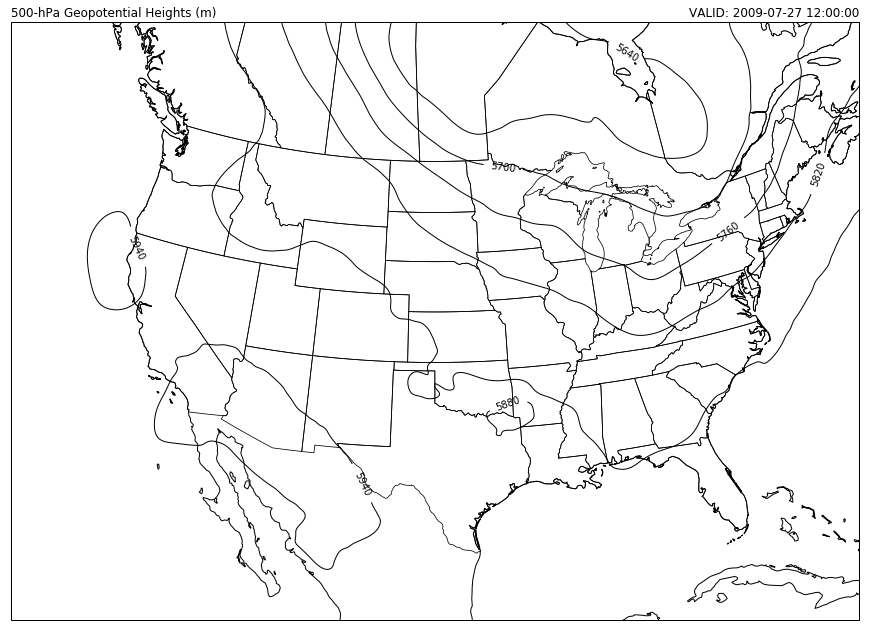

In [9]:
# Get data to plot state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='50m',
        facecolor='none')

# Set map projection
mapcrs = ccrs.LambertConformal(central_latitude=40,central_longitude=-100,standard_parallels=[30,60])

# Set up and plot figure
fig=plt.figure(1,figsize=(17.,11.))

# Set up the axes to plot on
ax = plt.subplot(111,projection=mapcrs)

# Set the graphic display extent (good to be a little smaller than data extent)
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([-125,-75,20,55],ccrs.Geodetic())

# Add coastlines and geopolitical lines (e.g., states) to our map
ax.coastlines('50m',edgecolor='black',linewidth=0.5)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.75)

# Plot our contours for the variable we want with contour labels
# With scalar variables like Geopotential Height and use of lat/lon for y/x
# we would need to use the ccrs.PlateCarree() for the transformation, not our datacrs.
clev500 = np.arange(0,7000,60)
cs = ax.contour(lons,lats,Z_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',
                transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot some titles and show
plt.title('500-hPa Geopotential Heights (m)',loc='left')
plt.title('VALID: %s' %(vtimes[0]),loc='right')
plt.show()

### Add Wind Barbs

Adding wind barbs is more complicated because the vector changes with the change in projection! This is where it is critical that we have a datacrs defined based on how the vectors are defined in our data.

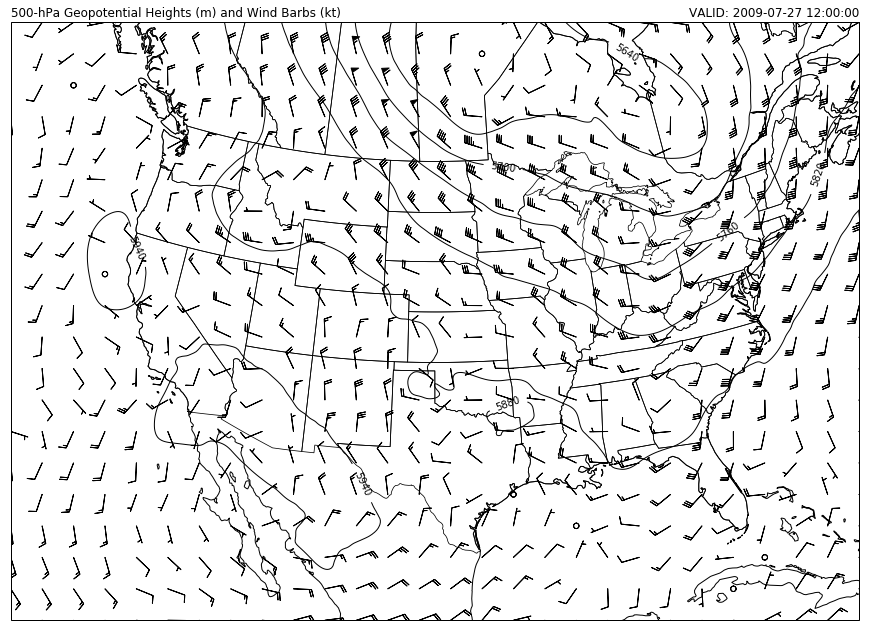

In [10]:
# Set map projection
mapcrs = ccrs.LambertConformal(central_latitude=40,central_longitude=-100,standard_parallels=[30,60])

# Set up and plot figure
fig=plt.figure(1,figsize=(17.,11.))

# Set up the axes to plot on
ax = plt.subplot(111,projection=mapcrs)

# Set graphic display extent
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([-125,-75,20,55],ccrs.Geodetic())

# Add geographical reference lines
ax.coastlines('50m',edgecolor='black',linewidth=0.5)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.75)

# Plot contours of our variable
clev500 = np.arange(0,7000,60)
cs = ax.contour(lons,lats,Z_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',
                transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Transform Vectors before plotting, then plot wind barbs.
# It is in the transformation that we need our original datacrs to have the vectors
# appear as they should on the map.
ut, vt = mapcrs.transform_vectors(datacrs,lons,lats,
                                  uwnd_500.m,vwnd_500.m)
# Still just the PlateCarree projection for plotting the now transformed
# barbs in the correct location based on our lat/lon values
ax.barbs(lons,lats,ut,vt,length=6,regrid_shape=20,
         transform=ccrs.PlateCarree())

# Plot some titles on our map
plt.title('500-hPa Geopotential Heights (m) and Wind Barbs (kt)',loc='left')
plt.title('VALID: %s' %(vtimes[0]),loc='right')
plt.show()

### Add isotachs

We can add multiple contours (or vectors) to any of our plots. Let's calcuate the 500-hPa wind speed and colorfill them on our plot.

In [11]:
# Calculate wind speed using MetPy function
wspd_500 = mcalc.get_wind_speed(uwnd_500,vwnd_500)

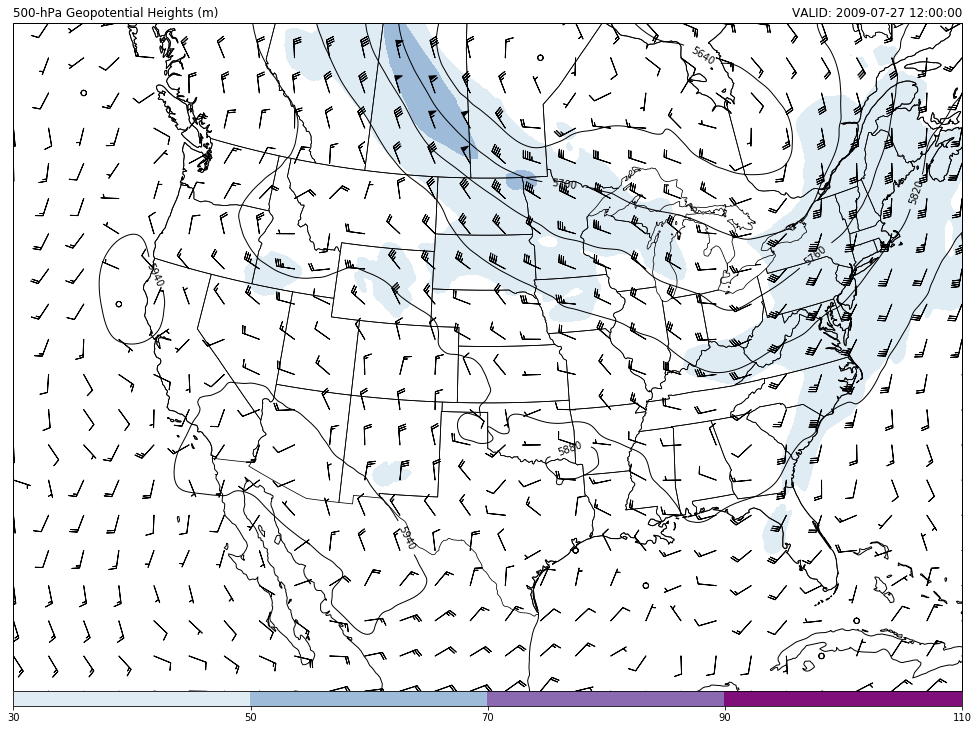

In [12]:
# Set map projection
mapcrs = ccrs.LambertConformal(central_latitude=40,central_longitude=-100,standard_parallels=[30,60])

# Set up and plot figure
fig=plt.figure(1,figsize=(17.,15.))

# Set up the axes to plot on
ax = plt.subplot(111,projection=mapcrs)

# Set graphic display extent
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([-125,-75,20,55],ccrs.Geodetic())

# Add geographical reference lines to plot
ax.coastlines('50m',edgecolor='black',linewidth=0.5)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.75)

# Plot contours of our variable
clev500 = np.arange(0,7000,60)
cs = ax.contour(lons,lats,Z_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',
                transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Add isotachs colorfill
cf = ax.contourf(lons, lats, wspd_500, range(30,111,20), cmap='BuPu', transform=ccrs.PlateCarree())
plt.colorbar(cf, orientation='horizontal', aspect=65, pad=0, extendrect='True')

# Transform Vectors before plotting, then plot wind barbs.
ut, vt = mapcrs.transform_vectors(datacrs,lons,lats,
                                  uwnd_500.m,vwnd_500.m)
ax.barbs(lons,lats,ut,vt,length=6,regrid_shape=20,
         transform=ccrs.PlateCarree())

# Plot titles on figure
plt.title('500-hPa Geopotential Heights (m)',loc='left')
plt.title('VALID: %s' %(vtimes[0]),loc='right')

plt.show()